# Network studies for Popular Logical Fallacies for CreateDebate forum

There are 13 different logical fallacies in the LOGIC dataset ([paper](https://arxiv.org/abs/2202.13758), [github](https://github.com/causalNLP/logical-fallacy)). We fine-tuned BERT (base, uncased) model on this datatset, and used it to classify comments in CreateDebate into one of the fallacies. The distribution of various fallacies is shown in the plot below.

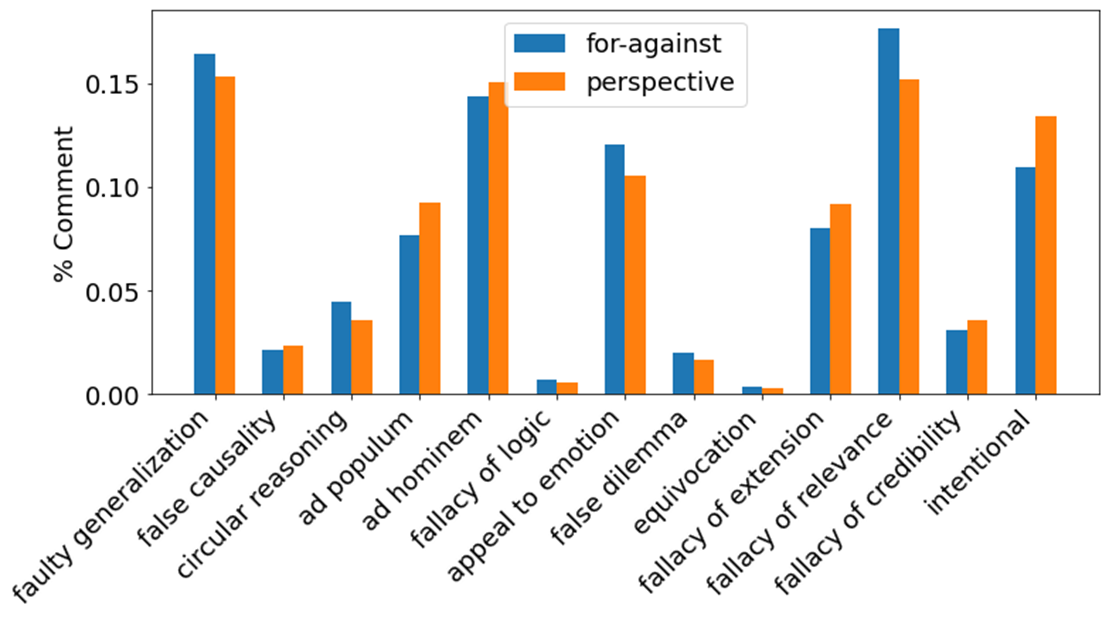

For this notebook, we will select top logical fallacies on the basis of their percentage in total comments, instead of complex clustering strategies.

The top 5 logical fallacies are:
* fallacy of relevance
* faulty generalization
* ad hominem
* intentional
* appeal to emotion

# Experimental setup

In [ ]:
# Mount Google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [ ]:
# Clone `CreateDebateScraper` library from github for handling
# CreateDebate dataset
!git clone https://github.com/utkarsh512/CreateDebateScraper.git
%cd CreateDebateScraper/src/nested/

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from thread import (Comment,
                    Thread)

from collections import deque
from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import networkx as nx
import spacy
import nltk 

In [ ]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (5, 5)

# Setup for nltk
nltk.download('punkt') # For tokenizers
nltk.download('stopwords')
nltk.download('wordnet') # For lemmatizers
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

# Loading dataset and some helper routines

In [ ]:
comments = dict()

# Topical forums on CreateDebate. We have scraped comments for all of the
# following forurm.
categories = ['business', 'comedy', 'entertainment', 'health', 'law', 'nsfw',
              'politics2', 'religion', 'science', 'shopping', 'sports',
              'technology', 'travel', 'world']

# However, we will be analyzing comments from selected forum only!
# These forum have at least 10k comments each.
categories_selected = ['politics2', 'religion', 'world', 
                       'science', 'law', 'technology']

for x in categories_selected:
    comments[x] = list()

In [ ]:
# Loading comments from select forums

for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')

    # Get all the `Thread` objects pickled while scraping.
    threads = list()
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()

    # While classifying CreateDebate comments, we used comments as per author mode.
    # Hence, using the same mode to attach classification score with the comments.
    # 
    # score < 0.5 -> ad hominem comment
    #       > 0.5 -> non ad hominem comment
    authors = dict()
    for thread in threads:
        for k, v in thread.comments.items():
            try:
                authors[v.author].append((v, k))
            except:
                authors[v.author] = list()
                authors[v.author].append((v, k))

    ctr = 0
    # Load the classification score of the comments.
    with open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/comments_with_score.log', 'rb') as fp:
        cws = pickle.load(fp)
    # Attach classification score with the comments.
    for author in authors.keys():
        for i in range(len(authors[author])):
            comment, cid = authors[author][i]
            foo = deepcopy(comment.__dict__)
            foo['tag'] = cat
            foo['score'] = cws[ctr][0]
            foo['validation'] = cws[ctr][1][0]
            foo['id'] = int(cid[3:])
            comments[cat].append(foo)
            ctr += 1

In [ ]:
# Loading CreateDebate profile characteristics into dataframe
df = pd.read_json('/content/gdrive/MyDrive/DL/CreateDebate/profile/results.json', lines=True)

# Extract useful characteristics
reward_points_map = {k : v for k, v in zip(df['username'].tolist(), df['reward_points'].tolist())}
efficiency_map    = {k : v for k, v in zip(df['username'].tolist(), df['efficiency'].tolist())}
allies_map        = {k : len(v) for k, v in zip(df['username'].tolist(), df['allies'].tolist())}
enemies_map       = {k : len(v) for k, v in zip(df['username'].tolist(), df['enemies'].tolist())}
hostiles_map      = {k : len(v) for k, v in zip(df['username'].tolist(), df['hostiles'].tolist())}

In [ ]:
def profile_characteristics_stats(user_subset):
    """
    Returns average and standard deviation of profile characteristics for 
    given subset of users.

    :param user_subset: Iterable containing usernames

    >>> avgs, stds = profile_characterisitics_stat(user_subset)
    >>> rewards_avg, efficiency_avg, n_allies_avg, n_enemies_avg, n_hostiles_avg = avgs
    >>> rewards_std, efficiency_std, n_allies_std, n_enemies_std, n_hostiles_std = stds

    Note that profile characteristics for some users might not be present in our
    dataset as some users might have deleted their account when we scraped the
    forum to obtain these characteristics.
    """
    rewards_ = list()
    efficiency_ = list()
    n_allies = list()
    n_enemies = list()
    n_hostiles = list()

    for user in user_subset:
        try:
            rewards_.append(reward_points_map[user])
        except:pass
        try:
            efficiency_.append(efficiency_map[user])
        except:pass
        try:
            n_allies.append(allies_map[user])
        except:pass
        try:
            n_enemies.append(enemies_map[user])
        except:pass
        try:
            n_hostiles.append(hostiles_map[user])
        except:pass
    
    grpd_data = [rewards_, efficiency_, n_allies, n_enemies, n_hostiles]
    avgs = [np.average(x) for x in grpd_data]
    stds = [np.std(x) for x in grpd_data]
    
    return avgs, stds

In [ ]:
user_list = set()

for category in categories_selected:
    for comment in comments[category]:
        user_list.add(comment['author'])

user_list = list(user_list)

In [ ]:
# Get a list of all comment thread representative to build user network graph

threads = []

for category in categories_selected:
    reader_addr = f'/content/gdrive/MyDrive/DL/CreateDebate/{category}/threads.log'
    reader = open(reader_addr, 'rb')
    try:
        while True:
            e = pickle.load(reader)
            threads.append(e)
    except:
        reader.close()

In [ ]:
def build_graph(user_subset, n1 = 0, n2 = 0):
    """
    Builds user network graph from hyper-parameters n1 and n2
    
    Inputs
    ------
    :param n1: threshold on number of level-1 comments
    :param n2: threshold on number of direct replies

    Output
    ------
    (
        author_map: dict,
        reverse_map: list,
        author_count: int, 
        graph: nx.DiGraph,
        matrix: list
    )
    """

    # Uses globally defined `threads` variable to construct this dictionary.
    # You may choose which categories to be included while building `threads`

    # key  : author name
    # value: count of level-1 comments
    athr = dict()

    for e in threads:
        if 'root' in e.metaL.keys():
            for key in e.metaL['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
        if 'root' in e.metaR.keys():
            for key in e.metaR['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
    
    # Filter those authors who satisfy the contraint on number of level-1 comments
    L1_athr = dict()
    for x in athr:
        if athr[x] >= n1:
            L1_athr[x] = True

    # Now use `athr` for storing count of direct replies
    # key  : author name
    # value: count of direct replies received
    athr = dict()

    # Depth-first search utility to get number of direct replies for each author
    def dfs(Map, cmntMap, athr, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs(Map[cid], cmntMap, athr, key)
            return

        cur_author = cmntMap[cid].author
        try:
            athr[cur_author] += len(Map[cid].keys())
        except:
            athr[cur_author] = len(Map[cid].keys())

        for key in Map[cid].keys():
            dfs(Map[cid], cmntMap, athr, key)

    # Traverse thread-tree to get number of direct replies for each author
    for e in threads:
        if 'root' in e.metaL.keys():
            dfs(e.metaL, e.comments, athr)
        if 'root' in e.metaR.keys():
            dfs(e.metaR, e.comments, athr) 
    
    # Filter authors who now satify both the contrainsts on count of 
    # - level-1 comments
    # - direct replies
    A = []
    for x in athr:
        if x not in user_subset:
            continue
        if athr[x] >= n2:
            try:
                z = L1_athr[x]
                A.append(x)
            except KeyError:
                pass

    # key  : author name
    # value: corresponing node number in the support/dispute network
    author_map = dict()

    # To get author name for node number
    reverse_map = ["" for _ in range(len(A))]
    author_count = len(A)

    for i in range(author_count):
        author_map[A[i]] = i
        reverse_map[i] = A[i]
    
    # Weighted adjacency matrices for user network
    # Weight for directed edge b/w Node A and Node B corresponsds to the number
    # of times Node A directly-replied Node B.
    matrix = [[0 for j in range(author_count)] for i in range(author_count)]

    # Depth-first search utility to build the adjacency matrices for graph.
    def dfs1(Map, cmntMap, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs1(Map[cid], cmntMap, key)
            return

        cur_author = cmntMap[cid].author
        
        if cur_author in author_map:
            cur_author_id = author_map[cur_author]
            for key in Map[cid].keys():
                nxt_author = cmntMap[key].author
                if nxt_author in author_map:
                    nxt_author_id = author_map[nxt_author]
                    matrix[nxt_author_id][cur_author_id] += 1

        for key in Map[cid].keys():
            dfs1(Map[cid], cmntMap, key)

    for e in threads:
        if 'root' in e.metaL:
            dfs1(e.metaL, e.comments)
        if 'root' in e.metaR:
            dfs1(e.metaR, e.comments)
        
    # Create NetworkX graphs from the adjacency matrices.
    # We need nx graphs in order to get various network stats provided in nx
    # library.
    graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if matrix[i][j] != 0:
                graph.add_weighted_edges_from([(i, j, matrix[i][j])])
    
    return (author_map, reverse_map, author_count, graph, matrix)

In [ ]:
# Construct global user network for entire CreateDebate corpus
user_map, user_reverse_map, user_count, Graph, Matrix = build_graph(user_list)

In [ ]:
def get_reciprocity_stats(user_subset):
    """
    Returns reciprocity for given subset of users in local network

    >>> r = get_reciprocity_stats(user_subset)
    """
    _, _, _, Graph_, _ = build_graph(user_subset)

    try:
        r = nx.algorithms.reciprocity(Graph_)
    except:
        r = None

    return r

In [ ]:
# Get dicts containing centrality value for each node from global network.
# This will be used for computing stats for user subset.
centrality_dict = nx.algorithms.centrality.degree_centrality(Graph)

In [ ]:
def get_centrality_stats(user_subset):
    """
    Returns mean and standard deviation of degree centrality for given user 
    subset in the global network.

    >>> c_avg, c_std = get_centrality_stats(user_subset)
    """
    c = []

    for user in user_subset:
        try:
            c.append(centrality_dict[user_map[user]])
        except:
            pass
    
    return np.average(c), np.std(c)

In [ ]:
# Get dicts containing clustering coeffieient for each node from global network. 
# This will be used for computing stats for user subset.
clustering_dict = nx.algorithms.cluster.clustering(Graph)

In [ ]:
def get_clustering_stats(user_subset):
    """
    Returns mean and standard deviation of clustering coefficient for given user 
    subset in the global network.

    >>> c_avg, c_std = get_clustering_stats(user_subset)
    """
    c = []

    for user in user_subset:
        try:
            c.append(clustering_dict[user_map[user]])
        except:
            pass
    
    return np.average(c), np.std(c)

In [ ]:
@lru_cache
def get_stats(user_subset):
    n                          = len(user_subset)
    r                          = get_reciprocity_stats(user_subset) 
    deg_avg, deg_std           = get_centrality_stats(user_subset)
    clu_avg, clu_std           = get_clustering_stats(user_subset)
    user_chr_avg, user_chr_std = profile_characteristics_stats(user_subset) 

    stats = dict()
    stats['n'] = n
    stats['r'] = r
    stats['deg_avg'] = deg_avg
    stats['deg_std'] = deg_std
    stats['clu_avg'] = clu_avg
    stats['clu_std'] = clu_std
    stats['reward_points_avg'] = user_chr_avg[0]
    stats['reward_points_std'] = user_chr_std[0]
    stats['eff_avg'] = user_chr_avg[1]
    stats['eff_std'] = user_chr_std[1]
    stats['allies_avg'] = user_chr_avg[2]
    stats['allies_std'] = user_chr_std[2]
    stats['enemies_avg'] = user_chr_avg[3]
    stats['enemies_std'] = user_chr_std[3]
    stats['hostiles_avg'] = user_chr_avg[4]
    stats['hostiles_std'] = user_chr_std[4]

    # print('Size: %d' % n)
    # print('Graph reciprocity: %.2f' % r)

    # print('Graph degree centrality: %.5f ± %.5f' % (deg_avg, deg_std))

    # print('Graph clustering coeff: %.2f ± %.2f' % (clu_avg, clu_std))

    # print('Reward points: %.2f ± %.2f' % (user_chr_avg[0], user_chr_std[0]))
    # print('Efficiency   : %.2f ± %.2f' % (user_chr_avg[1], user_chr_std[1]))
    # print('# Allies     : %.2f ± %.2f' % (user_chr_avg[2], user_chr_std[2]))
    # print('# Enemies    : %.2f ± %.2f' % (user_chr_avg[3], user_chr_std[3]))
    # print('# Hostiles   : %.2f ± %.2f' % (user_chr_avg[4], user_chr_std[4]))

    return stats

# Setup for Linguistic study

In [ ]:
def load_empath_dictionary():
    """
    Returns a dict[str, list] object where keys are categories and values are 
    associated words for that category
    """
    empath_dict = dict()
    with open('/content/gdrive/MyDrive/DL/empath/dictionary.tsv', 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            name = cols[0]
            terms = cols[1:]
            empath_dict[name] = list()
            for t in set(terms):
                empath_dict[name].append(t)
    return empath_dict

In [ ]:
empath = load_empath_dictionary()

In [ ]:
tokens_count = list()
for v in empath.values():
    tokens_count.append(len(v))

In [ ]:
print(f'Average token count {np.average(tokens_count)}, Std. dev {np.std(tokens_count)}')

In [ ]:
# We hand-picked categories that are more close to ad hominem triggers

empath_selected_tokens = list()

with open('/content/gdrive/MyDrive/DL/empath/empath_selected_categories.txt', 'r') as f:
    for line in f:
        empath_selected_tokens.append(line.strip())

In [ ]:
# SOTA slur word dictionary (from Punyajoy)
slur_words_dict = json.load(open('/content/gdrive/MyDrive/DL/slurwords/slur_dictionary.json'))

In [ ]:
# Combine selected empath tokens and slur words to create list of triggers

triggers = dict()
triggers.update(slur_words_dict)
for key in empath_selected_tokens:
    triggers[key] = list()
    for token in empath[key]:
        triggers[key].append(' '.join(token.split('_')))

In [ ]:
lemmatizer = WordNetLemmatizer()

triggers_lemma = dict()
for k in tqdm(triggers.keys()):
    triggers_lemma[k] = set(map(lemmatizer.lemmatize, triggers[k]))

In [ ]:
def create_dependency_graph(doc):
    """Create dependency graph of tokens using scapy
    """
    dependency_edges = list() # (parent, child, relationship)
    id_to_text = dict()
    id_to_token = dict()
    root = None
    node_count = 0

    for token in doc:
        node_count += 1
        parent = token.head.i
        child = token.i
        relationship = token.dep_
        id_to_text[child] = lemmatizer.lemmatize(token.text)
        id_to_token[child] = token
        if relationship == 'ROOT':
            root = child
            continue
        dependency_edges.append((parent, child, relationship))

    dependency_graph = dict()
    for i in range(node_count): 
        dependency_graph[i] = list()
    for p, c, r in dependency_edges:
        dependency_graph[p].append((c, r))
        dependency_graph[c].append((p, r))
    
    return dependency_graph, id_to_text, id_to_token, root

In [ ]:
def get_personal_pronoun_ids(id_to_token):
    """Generates ids which are indices of personal pronouns
    """
    for k, v in id_to_token.items():
        if v.tag_ == 'PRP': # Personal pronoun tag in scapy
            yield k

In [ ]:
def get_pronoun_ids(id_to_token):
    """Generates ids which are indices of pronouns
    """
    for k, v in id_to_token.items():
        if v.pos_ == 'PRON': # Pronoun tag in scapy
            yield k

In [ ]:
def get_trigger_ids(id_to_text, trigger_type):
    """Generates ids which are indices of triggers

    :param id_to_text: id_to_text returned by create_dependency_graph
    :type id_to_text: dict
    :param trigger_type: What type of triggers? Must be a key of triggers_lemma
    :type trigger_type: str
    """
    for k, v in id_to_text.items():
        if v in triggers_lemma[trigger_type]:
            yield k

In [ ]:
def breadth_first_search(dependency_graph, source):
    """Performs breadth first search

    :param dependency_graph: Dependency graph returned by create_dependency_graph
    :type dependency_graph: dict
    :param source: Source node ID
    :type source: int
    """
    q = deque()
    used = set()
    d = dict() # distance of nodes from source
    p = dict() # parent in bfs
    r = dict() # relation observed

    q.append(source)
    used.add(source)
    p[source] = -1
    d[source] = 0

    while len(q):
        v = q.popleft()
        for u, rel in dependency_graph[v]:
            if u in used:
                continue
            used.add(u)
            q.append(u)
            d[u] = d[v] + 1
            p[u] = v
            r[u] = rel

    return d, p, r

In [ ]:
def generate_path_from_bfs(source, dest, dist_dict, parent_dict, relation_dict):
    """Generate path from source to dest. Path will contain relationships 
    encountered in bfs.
    """
    assert dist_dict[source] == 0
    assert dest in dist_dict 

    path = list()
    cur = dest
    while cur != source:
        path.append(relation_dict[cur])
        cur = parent_dict[cur]
    
    return '->'.join(path)

In [ ]:
def get_trigger_count(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in triggers_lemma.keys():
        trigger_count[trigger_type] = 0

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in triggers_lemma.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        trigger_count[trigger_type] += 1
    
    return trigger_count

# Analysis

In [ ]:
for_against_debates = dict()
perspective_debates = dict()

for cat in categories_selected:
    for_against_debates[cat] = list()
    perspective_debates[cat] = list()

    for comment in comments[cat]:
        if comment['polarity'] == 'Not Available':
            perspective_debates[cat].append(deepcopy(comment))
        else:
            for_against_debates[cat].append(deepcopy(comment))

## Network study

In [ ]:
# For now, only Politics users are considered!
for_against_user_set = set()
perspective_user_set = set()

for comment in for_against_debates['politics2']:
    for_against_user_set.add(comment['author'])

for comment in perspective_debates['politics2']:
    perspective_user_set.add(comment['author'])

print(f'{len(for_against_user_set)} & {len(perspective_user_set)}')

In [ ]:
# Encoding labels used while classification.
# Refer to notebook#63.
label_map = {
    'faulty generalization': 0,
    'false causality': 1,
    'circular reasoning': 2, 
    'ad populum': 3,
    'ad hominem': 4,
    'fallacy of logic': 5,
    'appeal to emotion': 6,
    'false dilemma': 7,
    'equivocation': 8,
    'fallacy of extension': 9,
    'fallacy of relevance': 10,
    'fallacy of credibility': 11,
    'intentional': 12,
}

inverse_label_map = dict()
for k, v in label_map.items():
    inverse_label_map[v] = k

In [ ]:
def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [ ]:
# Load labels and scores obtained during classification 
for_against_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-for_against_labels_and_scores.pkl')
perspective_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-perspective_labels_and_scores.pkl')

In [ ]:
for_against_logical = dict()
perspective_logical = dict()
# key: logical fallacy class
# value: list of comments 

for k in label_map.keys():
    for_against_logical[k] = list()
    perspective_logical[k] = list()

In [ ]:
for comment, labels_and_scores in zip(for_against_debates['politics2'], for_against_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    for_against_logical[inverse_label_map[label]].append(comment)

In [ ]:
for comment, labels_and_scores in zip(perspective_debates['politics2'], perspective_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    perspective_logical[inverse_label_map[label]].append(comment)

In [ ]:
@lru_cache
def get_user_subset_for_against(cls, flag=0):
    user_subset = set()
    for comment in for_against_logical[cls]:
        user_subset.add(comment['author'])
    if flag:
        user_subset = for_against_user_set - user_subset
    return frozenset(user_subset)

@lru_cache
def get_user_subset_perspective(cls, flag=0):
    user_subset = set()
    for comment in perspective_logical[cls]:
        user_subset.add(comment['author'])
    if flag:
        user_subset = perspective_user_set - user_subset
    return frozenset(user_subset)

In [ ]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization', 
                    'ad hominem', 
                    'intentional',
                    'appeal to emotion')

In [ ]:
def analyze_for_against(property, label, flag=0):
    data = list()
    for cls in classes_selected:
        user_subset = get_user_subset_for_against(cls=cls, flag=flag)
        stats = get_stats(user_subset)
        data.append((cls, stats[property]))

    data = sorted(data, reverse=True, key=lambda z: z[1])
    x, y = [], []

    if flag:
        for cls, val in data:
            x.append(f'~{cls}')
            y.append(val)
    else:
        for cls, val in data:
            x.append(cls)
            y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    ax = sns.barplot(data=plt_data, x='x', y='y')
    ax.set_title(f'For-Against: {label}', color='black')
    ax.set_ylabel(label)
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.plot()

In [ ]:
def analyze_perspective(property, label, flag=0):
    data = list()
    for cls in classes_selected:
        user_subset = get_user_subset_perspective(cls=cls, flag=flag)
        stats = get_stats(user_subset)
        data.append((cls, stats[property]))

    data = sorted(data, reverse=True, key=lambda z: z[1])
    x, y = [], []

    if flag:
        for cls, val in data:
            x.append(f'~{cls}')
            y.append(val)
    else:
        for cls, val in data:
            x.append(cls)
            y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    ax = sns.barplot(data=plt_data, x='x', y='y')
    ax.set_title(f'Perspective: {label}', color='black')
    ax.set_ylabel(label)
    ax.set_xticklabels(x, rotation=45, ha='right')
    ax.plot()

In [ ]:
global_stats = get_stats(tuple(user_list))

In [ ]:
global_stats.keys()

In [ ]:
analyze_for_against('hostiles_avg', '#hostiles')

In [ ]:
analyze_perspective('hostiles_avg', '#hostiles')

## Linguistic study

In [ ]:
for_against_texts = dict()
perspective_texts = dict()

for k in classes_selected:
    for_against_texts[k] = [comment['body'].lower() for comment in for_against_logical[k]]
    perspective_texts[k] = [comment['body'].lower() for comment in perspective_logical[k]]

In [ ]:
for_against_trigger_count = dict()
perspective_trigger_count = dict()

for cls in classes_selected:
    print(cls)
    for_against_trigger_count[cls] = get_trigger_count(for_against_texts[cls], get_personal_pronoun_ids)
    perspective_trigger_count[cls] = get_trigger_count(perspective_texts[cls], get_personal_pronoun_ids)

In [ ]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization', 
                    'ad hominem', 
                    'intentional',
                    'appeal to emotion')

short_label = {
    'fallacy of relevance': 'R',
    'faulty generalization': 'G',
    'ad hominem': 'A',
    'intentional': 'I',
    'appeal to emotion': 'E'
}

In [ ]:
def analyze_for_against(property, ax):
    data = list()
    for cls in classes_selected:
        data.append((cls, for_against_trigger_count[cls][property] / len(for_against_texts[cls])))

    data = sorted(data, reverse=True, key=lambda z: z[1])
    x, y = [], []

    for cls, val in data:
        x.append(short_label[cls])
        y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    sns.barplot(data=plt_data, x='x', y='y', ax=ax)
    ax.set_title(f'For-Against: {property}', color='black')
    ax.set_ylabel('count')

In [ ]:
def analyze_perspective(property, ax):
    data = list()
    for cls in classes_selected:
        data.append((cls, perspective_trigger_count[cls][property] / len(perspective_texts[cls])))

    data = sorted(data, reverse=True, key=lambda z: z[1])
    x, y = [], []

    for cls, val in data:
        x.append(short_label[cls])
        y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    sns.barplot(data=plt_data, x='x', y='y', ax=ax)
    ax.set_title(f'Perspective: {property}', color='black')
    ax.set_ylabel('count')

In [ ]:
tokens = list(triggers_lemma.keys())

In [ ]:
fig, axes = plt.subplots(len(tokens), 2, figsize=(10, 5 * len(tokens)))
fig.suptitle('Linguistic Study for Popular Logical Fallacies in CreateDebate')

for i, token in enumerate(tokens):
    analyze_for_against(token, axes[i, 0])
    analyze_perspective(token, axes[i, 1])

fig.savefig("network-study.pdf")

In [ ]:
analyze_perspective2(trigger_type)